<a href="https://colab.research.google.com/github/LeonardoVieiraGuimaraes/MiniCursoPalestra/blob/main/CNN/reconhecerNumero/simple_cnn_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN simples para Google Colab (treino MNIST)

Resumo: Este notebook prepara, treina e avalia uma CNN simples no conjunto MNIST. Ele foi pensado para rodar no Google Colab (GPU opcional) ou localmente em um ambiente Python com TensorFlow instalado.

Pré-requisitos:
- Python 3.8+ e TensorFlow compatível (no Colab, o runtime já oferece TF).
- (Opcional) GPU no Colab para acelerar o treinamento.

Como usar:
1. Execute as células na ordem apresentada.
2. Na célula de instalação (se em Colab) permita a instalação de dependências quando solicitado.
3. Ajuste hiperparâmetros (epochs, batch_size) na célula de treino se desejar.
4. Ao final, salve o modelo com a célula de salvamento (opcionalmente no Google Drive).

Arquivos gerados esperados:
- `best_model.h5` (melhor checkpoint local).
- `simple_cnn_mnist.h5` (arquivo salvo opcional).

Entradas / Saídas:
- Entrada: nenhum arquivo externo é necessário (os dados MNIST são baixados automaticamente).
- Saída: modelos salvos em disco + gráficos do histórico de treino e métricas de teste.

Notas e dicas:
- Use `validation_split` pequeno (ex.: 0.1) para validação rápida.
- Se desejar reproduzir resultados, defina uma semente RNG antes do trecho de treino.
- Para experimentar com outros datasets (Fashion-MNIST, CIFAR-10), adapte a célula de carregamento dos dados.

Instalação condicional (Colab):
Detecta execução em Colab e instala pacotes; atenção: evitar reinstalar TensorFlow no Colab para não causar conflitos.

In [7]:
# ...existing code...
import sys
import subprocess
import importlib

# pacotes requeridos: chave = nome pip, valor = nome do módulo para import
REQUIRED = {
    "numpy": "numpy",
    "pandas": "pandas",
    "scikit-learn": "sklearn",
    "matplotlib": "matplotlib",
    "joblib": "joblib",
    "tensorflow": "tensorflow"
}

def install(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", pkg])

print("Instalando dependências ausentes (sem montar Drive)...")
for pkg, mod in REQUIRED.items():
    try:
        importlib.import_module(mod)
        print(f"  {mod}: ok")
    except Exception:
        print(f"  {mod}: não encontrado — instalando {pkg} ...")
        install(pkg)

def versoes():
    out = {}
    for pkg, mod in REQUIRED.items():
        try:
            m = importlib.import_module(mod)
            out[mod] = getattr(m, "__version__", "ok")
        except Exception:
            out[mod] = None
    return out

print("Versões (None = não disponível):", versoes())

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print('TensorFlow version:', tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print('GPUs found:', gpus)




Instalando dependências ausentes (sem montar Drive)...
  numpy: ok
  pandas: ok
  sklearn: ok
  matplotlib: ok
  joblib: ok
  tensorflow: ok
Versões (None = não disponível): {'numpy': '2.3.3', 'pandas': '2.3.3', 'sklearn': '1.7.2', 'matplotlib': '3.10.7', 'joblib': '1.5.2', 'tensorflow': '2.20.0'}
TensorFlow version: 2.20.0
GPUs found: []


Checar ambiente:
Importa as bibliotecas principais e mostra versão do TensorFlow e GPUs disponíveis. Útil para confirmar que o ambiente tem aceleração por hardware.

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print('TensorFlow version:', tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print('GPUs found:', gpus)

TensorFlow version: 2.20.0
GPUs found: []


Carregar MNIST e pré-processar:
Baixa MNIST (se necessário), normaliza pixels para [0,1] e ajusta dimensões para o modelo (batch, height, width, channel). Mostra algumas amostras.

x_train shape: (60000, 28, 28, 1) y_train shape: (60000,)


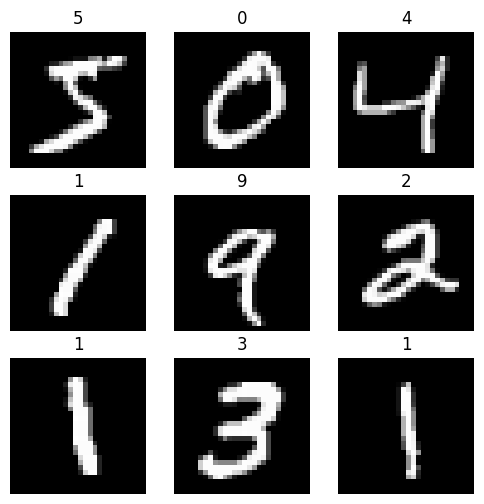

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalizar e expandir canal
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)  # (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, -1)

print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)

# Mostrar as 9 primeiras imagens de treino
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(str(y_train[i]))
    plt.axis('off')
plt.show()

Definir arquitetura da CNN:
Função que constrói um modelo Sequential teste com duas camadas convolucionais, pooling, flatten e dense final. Use essa célula para modificar arquitetura ou hiperparâmetros.

In [10]:
from tensorflow.keras import layers, models

def build_simple_cnn(input_shape=(28,28,1), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_simple_cnn()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Compilar e treinar:
Compila o modelo com optimizer e loss e inicia o treinamento com EarlyStopping e ModelCheckpoint para salvar o melhor estado.

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Salvar melhor modelo localmente (runtime)
checkpoint_path = 'best_model.h5'
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
]

history = model.fit(x_train, y_train,
                    epochs=15,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=callbacks)

Epoch 1/15
420/422 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8103 - loss: 0.5991

422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9119 - loss: 0.2836 - val_accuracy: 0.9842 - val_loss: 0.0594
Epoch 2/15
419/422 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9700 - loss: 0.0971

422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9728 - loss: 0.0886 - val_accuracy: 0.9877 - val_loss: 0.0428
Epoch 3/15
419/422 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9809 - loss: 0.0645

422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9815 - loss: 0.0635 - val_accuracy: 0.9902 - val_loss: 0.0324
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9836 - loss: 0.0523 - val_accuracy: 0.9895 - val_loss: 0.0335
Epoch 5/15
419/422 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9864 - loss: 0.0429

422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9862 - loss: 0.0437 - val_accuracy: 0.9915 - val_loss: 0.0291
Epoch 6/15
417/422 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9902 - loss: 0.0326

422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9891 - loss: 0.0359 - val_accuracy: 0.9927 - val_loss: 0.0273
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9904 - loss: 0.0316 - val_accuracy: 0.9912 - val_loss: 0.0308
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9918 - loss: 0.0269 - val_accuracy: 0.9922 - val_loss: 0.0279
Epoch 9/15
420/422 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9924 - loss: 0.0229

422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9924 - loss: 0.0236 - val_accuracy: 0.9920 - val_loss: 0.0256
Epoch 10/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9933 - loss: 0.0213 - val_accuracy: 0.9917 - val_loss: 0.0287
Epoch 11/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9936 - loss: 0.0187 - val_accuracy: 0.9913 - val_loss: 0.0320
Epoch 12/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9941 - loss: 0.0177 - val_accuracy: 0.9918 - val_loss: 0.0325
Epoch 13/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9941 - loss: 0.0177 - val_accuracy: 0.9920 - val_loss: 0.0294
Epoch 14/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9953 - loss: 0.0150 - val_accuracy: 0.9923 - val_loss: 0.0305


Plot das curvas de treino:
Plota loss/val_loss e accuracy/val_accuracy usando o histórico retornado pelo `model.fit`. Útil para inspecionar overfitting ou instabilidade.

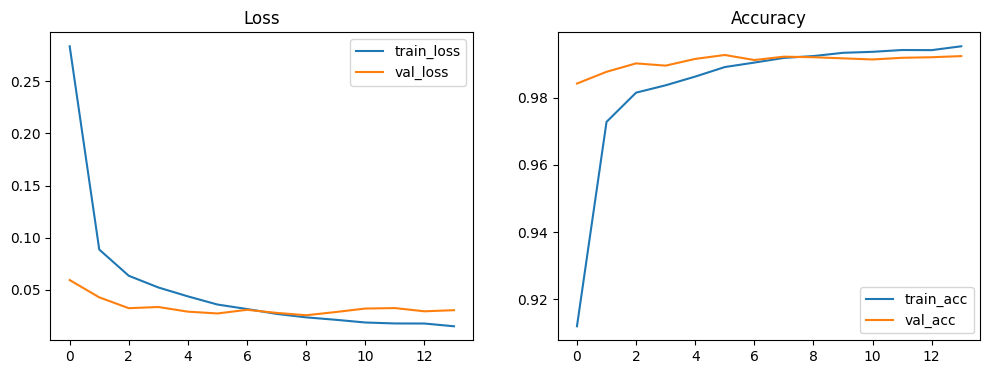

In [12]:
# Plot das curvas de treino/validação
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')
plt.show()

Avaliar no conjunto de teste:
Executa `model.evaluate` sobre `x_test`/`y_test` e imprime métricas finais. Se quiser avaliar o checkpoint salvo, carregue `best_model.h5` antes.

In [13]:
# Avaliar no conjunto de teste
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')

313/313 - 1s - 2ms/step - accuracy: 0.9928 - loss: 0.0214
Test accuracy: 0.9928, Test loss: 0.0214


Visualizar previsões:
Mostra as primeiras 25 imagens do conjunto de teste com previsões e coloração dos rótulos (verde correto, vermelho incorreto).

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


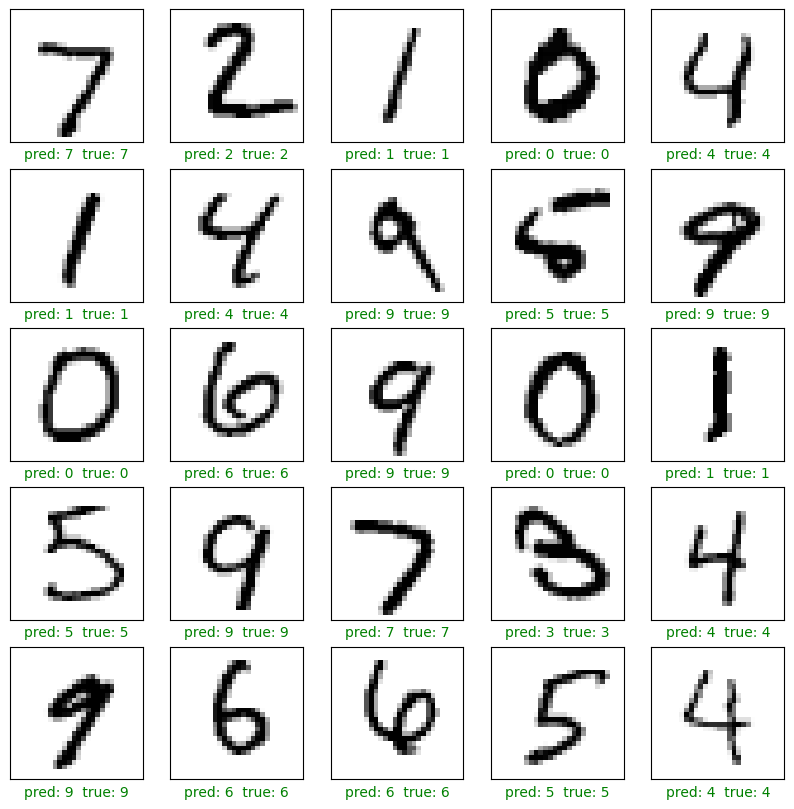

In [14]:
preds = model.predict(x_test[:25])
pred_labels = np.argmax(preds, axis=1)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i].squeeze(), cmap=plt.cm.binary)
    color = 'green' if pred_labels[i] == y_test[i] else 'red'
    plt.xlabel(f'pred: {pred_labels[i]}  true: {y_test[i]}', color=color)
plt.show()

Salvar modelo no Drive (opcional):
Se estiver no Colab, monte o Drive e salve o modelo. Em ambiente local, salva no arquivo `simple_cnn_mnist.h5`.

In [ ]:
# Salva o modelo e metadata na pasta `model/` (não usa Drive)
# Salva o modelo e metadata na pasta `model/` (não usa Drive)
try:
    model
except NameError:
    raise RuntimeError("Variável 'model' não encontrada. Execute a célula de treino antes.")

import os
import numpy as np

os.makedirs("model", exist_ok=True)
model_path = os.path.join("model", "simple_cnn_mnist.keras")
model.save(model_path)
print("Modelo salvo em:", model_path)

# Salva metadata usada pela inferência
meta_path = os.path.join("model", "simple_cnn_metadata.npz")
np.savez_compressed(meta_path,
                    image_size=(28, 28),
                    input_shape=(28, 28, 1),
                    class_names=np.array([str(i) for i in range(10)], dtype=object))
print("Metadata salva em:", meta_path)

Modelo salvo localmente em simple_cnn_mnist.h5


In [17]:

import os
import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

# Carrega metadata (fallback para defaults MNIST)
def load_metadata():
    candidates = [
        "model/simple_cnn_metadata.npz",
        "simple_cnn_metadata.npz",
        "model/simple_cnn_metadata.npz"
    ]
    for p in candidates:
        if os.path.exists(p):
            meta = np.load(p, allow_pickle=True)
            image_size = tuple(meta.get("image_size", (28, 28)))
            input_shape = tuple(meta.get("input_shape", (28, 28, 1)))
            class_names = meta.get("class_names", [str(i) for i in range(10)])
            class_names = [c.decode() if isinstance(c, (bytes, bytearray)) else str(c) for c in class_names]
            print("Metadata carregada de:", p)
            return image_size, input_shape, class_names
    # defaults
    print("Metadata não encontrada — usando defaults MNIST.")
    return (28, 28), (28, 28, 1), [str(i) for i in range(10)]

IMAGE_SIZE, INPUT_SHAPE, CLASS_NAMES = load_metadata()

# Localiza e carrega modelo (tenta .keras, .h5, ou SavedModel dir)
def find_and_load_model():
    candidates = [
        "model/simple_cnn_mnist.keras",
        "model/simple_cnn_mnist.h5",
        "simple_cnn_mnist.h5",
        "best_model.h5",
        "model/best_model.h5",
        "model"  # SavedModel dir
    ]
    for c in candidates:
        if os.path.exists(c):
            try:
                print("Tentando carregar modelo:", c)
                model = tf.keras.models.load_model(c)
                print("Modelo carregado de:", c)
                return model
            except Exception as e:
                print("Falha ao carregar", c, ":", e)
    raise FileNotFoundError("Nenhum modelo encontrado. Coloque o arquivo .keras/.h5 em 'model/' ou no runtime.")

# Pré-processamento de imagem PIL -> batch ready
def preprocess_pil_image(img_pil, image_size=IMAGE_SIZE):
    if img_pil.mode != "L":
        img = img_pil.convert("L")
    else:
        img = img_pil
    img = img.resize(image_size, Image.Resampling.BILINEAR)
    arr = np.asarray(img).astype("float32") / 255.0
    if arr.ndim == 2:
        arr = np.expand_dims(arr, -1)
    arr = np.expand_dims(arr, 0)  # (1, H, W, C)
    return arr

# Prediz de bytes de imagem
def predict_image_bytes(image_bytes, model):
    img = Image.open(io.BytesIO(image_bytes))
    x = preprocess_pil_image(img)
    probs = model.predict(x)[0]
    idx = int(np.argmax(probs))
    return {"label": CLASS_NAMES[idx], "index": idx, "score": float(probs[idx]), "probs": probs}

# Prediz de caminho local
def predict_image_path(path, model, show=True):
    with open(path, "rb") as f:
        res = predict_image_bytes(f.read(), model)
    if show:
        img = Image.open(path).convert("L").resize(IMAGE_SIZE, Image.Resampling.BILINEAR)
        plt.imshow(np.asarray(img), cmap="gray")
        plt.title(f"{os.path.basename(path)} → {res['label']} ({res['score']:.3f})")
        plt.axis("off")
        plt.show()
    return res

# Prediz de URL (usa requests)
def predict_image_url(url, model, show=True):
    try:
        import requests
    except Exception:
        raise RuntimeError("requests não instalado. Execute: pip install requests")
    r = requests.get(url, timeout=10)
    r.raise_for_status()
    res = predict_image_bytes(r.content, model)
    if show:
        img = Image.open(io.BytesIO(r.content)).convert("L").resize(IMAGE_SIZE, Image.Resampling.BILINEAR)
        plt.imshow(np.asarray(img), cmap="gray")
        plt.title(f"URL → {res['label']} ({res['score']:.3f})")
        plt.axis("off")
        plt.show()
    return res

# Interface interativa: upload (Colab) ou usar arquivo local/quatro.jpg
def infer_interactive(model):
    if IN_COLAB:
        print("Selecione uma imagem para upload (Colab).")
        uploaded = files.upload()
        for fname, content in uploaded.items():
            r = predict_image_bytes(content, model)
            print(fname, "→", r["label"], f"score={r['score']:.4f}")
    else:
        sample = "quatro.jpg"
        if os.path.exists(sample):
            r = predict_image_path(sample, model, show=True)
            print(r)
        else:
            print("Nenhuma imagem local encontrada. Use predict_image_path(path, model) ou predict_image_url(url, model).")

# Uso: carregar modelo e chamar as funções acima
if __name__ == "__main__":
    try:
        model = find_and_load_model()
    except FileNotFoundError as e:
        print(e)
        model = None
    print("IMAGE_SIZE:", IMAGE_SIZE, "INPUT_SHAPE:", INPUT_SHAPE, "N classes:", len(CLASS_NAMES))
    # Exemplos de uso (descomente para testar):
    # infer_interactive(model)
    # print(predict_image_path("quatro.jpg", model))
    # print(predict_image_url("https://example.com/some_digit.png", model))
    # Para batch CSV com coluna 'filename', carregue pandas e itere os caminhos.

Metadata não encontrada — usando defaults MNIST.
Tentando carregar modelo: simple_cnn_mnist.h5
Modelo carregado de: simple_cnn_mnist.h5
IMAGE_SIZE: (28, 28) INPUT_SHAPE: (28, 28, 1) N classes: 10
